In [ ]:
from scipy.io import loadmat
import scipy.io

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import os
import sklearn
from sklearn.utils import shuffle
import random
import tqdm
from tqdm import tqdm
import json
from tensorflow.keras.utils import plot_model

# Get Data

In [ ]:
def trip(img):
  return np.stack([img,img,img],-1)

def get_img(patient,day,n,eye=np.random.randint(0,2)):
  f_img = f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Normalized/{patient}/{day}.mat'
  img = loadmat(f_img)['data'][0,0][eye][0,0][1][n]

  return trip(img)

def get_label(patient,day,n,eye=np.random.randint(0,2)):
  f_ann = f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Original/{patient}/{day}/annotation.txt'
  with open(f_ann, 'r') as f: x,y,z = map(float,f.readlines()[n].split()[26:29])
  norm = np.linalg.norm([x,y,z])
  x /= norm
  y /= norm
  z /= norm

  theta = math.asin(-y)*180./np.pi
  phi = math.atan2(-x,-z)*180./np.pi

  return np.array([theta, phi])

def get_data(patient,day,n,eye=np.random.randint(0,2)):
  img = get_img(patient,day,n,eye)
  label = get_label(patient,day,n,eye)

  return img, label

def get_day(patient,day):
  f_img = f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Normalized/{patient}/{day}.mat'
  data = loadmat(f_img)['data']

  f_ann = f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Original/{patient}/{day}/annotation.txt'
  lines = []
  with open(f_ann, 'r') as f: lines = f.readlines()
  labels = []
  for line in lines:
    x,y,z = list(map(float,line.split()))[26:29]
    norm = np.linalg.norm([x,y,z])
    x /= norm
    y /= norm
    z /= norm

    theta = math.asin(-y)*180./np.pi
    if theta < 0: theta += 360.
    phi = math.atan2(-x,-z)*180./np.pi
    if phi < 0: phi += 360.
    labels.append(np.array([theta,phi]))

  size = len(labels)

  imgs = []

  for i in range(size):
    imgs.append(data[0,0][np.random.randint(0,2)][0,0][1][i])

  return imgs, labels

def get_patient(patient):
  days = [day.replace('.mat','') for day in os.listdir(f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Normalized/{patient}') if '.mat' in day]
  imgs = []
  labels = []
  for day in days:
    dimg, dlabel = get_day(patient,day)
    imgs.extend(dimg)
    labels.extend(dlabel)
  return imgs, labels

def get_dataset(patients):
  x = []
  y = []
  for patient in tqdm(patients):
    imgs, labels = get_patient(patient)
    x.extend(imgs)
    y.extend(labels)
  x, y = shuffle(x,y,random_state=42)
  return x, y

In [ ]:
patients = [p for p in os.listdir('/content/drive/MyDrive/MPII/MPIIGaze/Data/Normalized')]

In [ ]:
random.Random(32).shuffle(patients)

In [ ]:
train_patients = patients[:11]
val_patients = patients[11:13]
test_patients = patients[13:]

In [ ]:
x_train, y_train = get_dataset(train_patients)

100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


In [ ]:
x_val, y_val = get_dataset(val_patients)

100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


In [ ]:
x_test, y_test = get_dataset(test_patients)

100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


In [ ]:
np.save('/content/drive/MyDrive/MPII/MPIIGaze/x_train.npy', x_train)

In [ ]:
np.save('/content/drive/MyDrive/MPII/MPIIGaze/x_val.npy', x_val)

In [ ]:
np.save('/content/drive/MyDrive/MPII/MPIIGaze/x_test.npy', x_test)

In [ ]:
np.save('/content/drive/MyDrive/MPII/MPIIGaze/y_train.npy', y_train)

In [ ]:
np.save('/content/drive/MyDrive/MPII/MPIIGaze/y_val.npy', y_val)

In [ ]:
np.save('/content/drive/MyDrive/MPII/MPIIGaze/y_test.npy', y_test)

In [ ]:
x_train = np.load('/content/drive/MyDrive/MPII/MPIIGaze/x_train.npy')
x_val = np.load('/content/drive/MyDrive/MPII/MPIIGaze/x_val.npy')
x_test = np.load('/content/drive/MyDrive/MPII/MPIIGaze/x_test.npy')

y_train = np.load('/content/drive/MyDrive/MPII/MPIIGaze/y_train.npy')
y_val = np.load('/content/drive/MyDrive/MPII/MPIIGaze/y_val.npy')
y_test = np.load('/content/drive/MyDrive/MPII/MPIIGaze/y_test.npy')

# Make Model

In [ ]:
!pip install -U -q tensorflow-addons
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 50
image_size = (36,60)

num_classes = 2
input_shape = (36, 60, 3)

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size[0], image_size[1], 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255)
    ],
    name="data_augmentation",
)

def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes, activation='relu')(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[
            'mse'
        ],
    )

    checkpoint_filepath = "/content/drive/MyDrive/MPII/MPIIGaze/cct_model_weights.hdf5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=trip(x_train),
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(trip(x_val), y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    return model, history

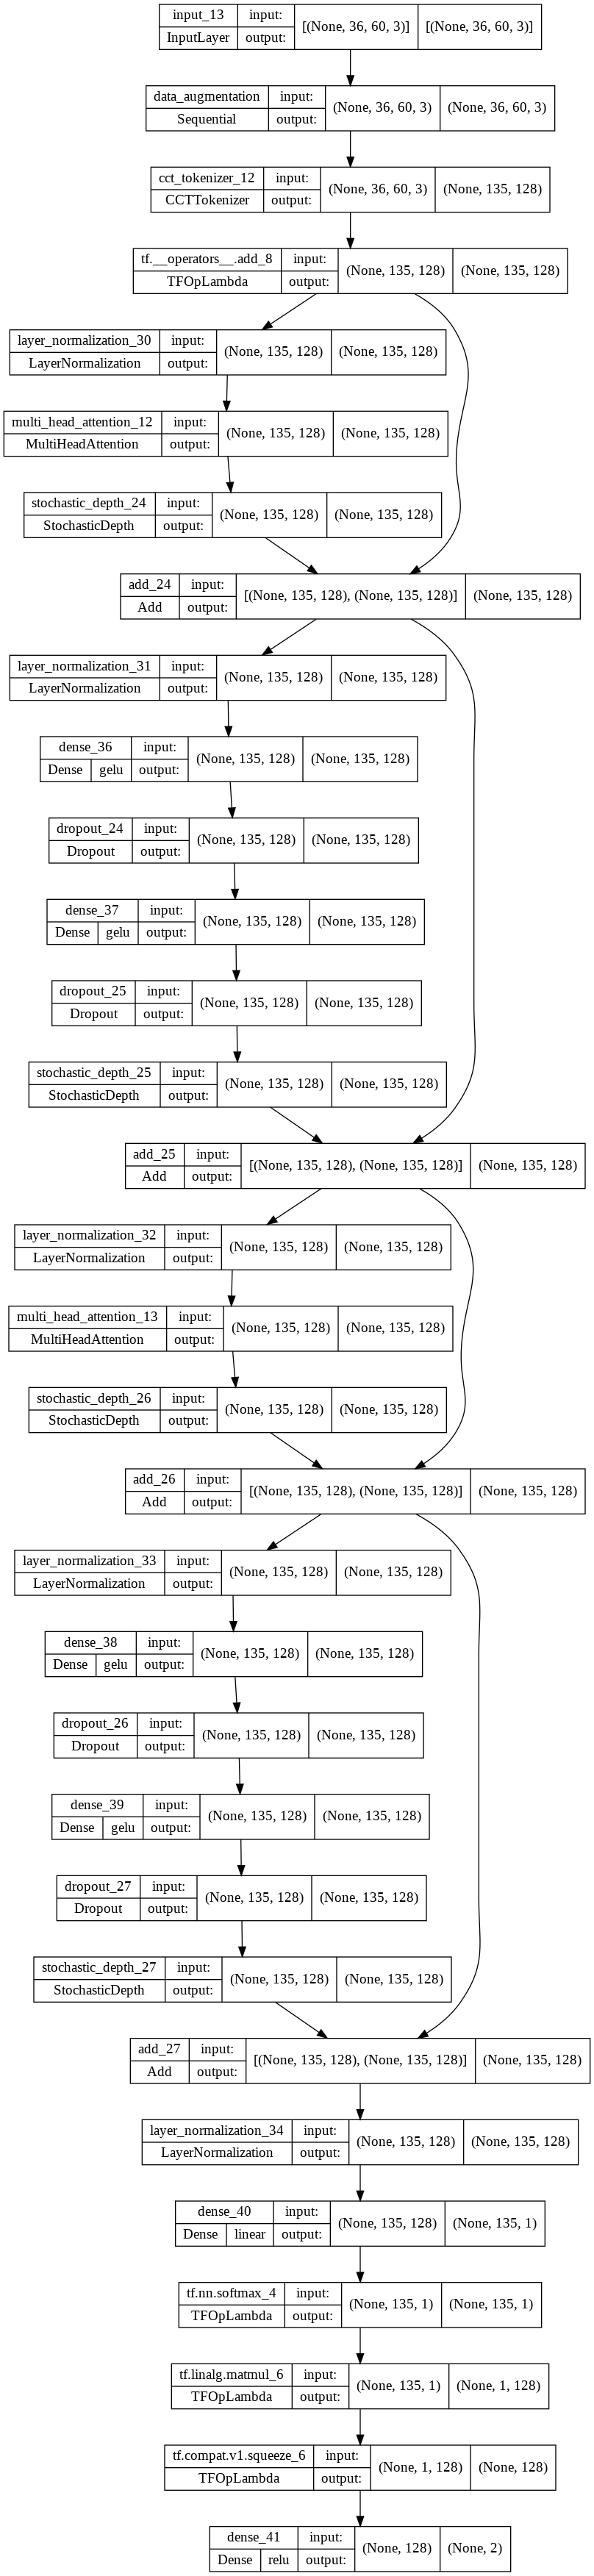

In [ ]:
cct_model = create_cct_model()
plot_model(cct_model, show_shapes=True, show_layer_activations=True)

In [ ]:
cct_model, cct_history = run_experiment(cct_model)
json.dump(cct_history.history, open('/content/drive/MyDrive/MPII/MPIIGaze/cct_history.json','w'))

Epoch 1/50
9707/9707 [==============================] - 141s 14ms/step - loss: 5419.0269 - mse: 5419.0269 - val_loss: 2999.2439 - val_mse: 2999.2439
Epoch 2/50
9707/9707 [==============================] - 135s 14ms/step - loss: 2845.9451 - mse: 2845.9451 - val_loss: 3187.8352 - val_mse: 3187.8352
Epoch 3/50
9707/9707 [==============================] - 134s 14ms/step - loss: 2748.3252 - mse: 2748.3252 - val_loss: 3096.1482 - val_mse: 3096.1482
Epoch 4/50
9707/9707 [==============================] - 134s 14ms/step - loss: 2698.5442 - mse: 2698.5442 - val_loss: 3463.6606 - val_mse: 3463.6606
Epoch 5/50
9707/9707 [==============================] - 133s 14ms/step - loss: 2673.8296 - mse: 2673.8296 - val_loss: 4097.2310 - val_mse: 4097.2310
Epoch 6/50
9707/9707 [==============================] - 132s 14ms/step - loss: 2652.8523 - mse: 2652.8523 - val_loss: 3543.0586 - val_mse: 3543.0586
Epoch 7/50
9707/9707 [==============================] - 132s 14ms/step - loss: 2653.1111 - mse: 2653.1111 

In [ ]:
print(cct_model.evaluate(trip(x_test), y_test))

820/820 [==============================] - 7s 9ms/step - loss: 1434.5399 - mse: 1434.5399
[1434.5399169921875, 1434.5399169921875]
